**Predicting Media Memorability**

*The task of Predicting Media Memorability is part of the MediaEval Multimedia Assessment benchmarking initiative. The objective of this task is to automatically predict a memorability score for a video that will represent its probability of being remembered.*  

**Content:**


*   **Section 1** : Function Definitions
*   **Section 2** : Loading Features
*   **Section 3** : Data Pre-processing and Input feature generation
    *   CountVectorizer
    *   TfidfVectorizer 
    *   One-hot encoding 
*   **Section 4** : Modelling
    *   Input : CountVectorizer
        * Model : Sequential Neural Network
        * Model : Decision Tree Regression
        * Model : Random Forest Regression
    *   Input : TfidfVectorizer
        * Model : Sequential Neural Network
        * Model : Decision Tree Regression
        * Model : Random Forest Regression
    *   Input : One-Hot Encoding
        * Model : Sequential Neural Network
        * Model : Decision Tree Regression
        * Model : Random Forest Regression
*   **Section 5** : Building Ensemble models with the best predictions
*   **Section 6** : Results   







**Section 1** : Function Definitions

In [0]:
def Get_score(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])

In [0]:
from google.colab import drive
import os
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/CA684_Assignment/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
pip install PyPrind

Importing Necesarry libraries

In [0]:
import pandas as pd
from tensorflow.python.keras import Sequential
from tensorflow.python.keras import layers
from tensorflow.python.keras import regularizers
import numpy as np
from string import punctuation
import pyprind
from collections import Counter
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
# for reproducability
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)

**Section 2** : Loading Features

In [0]:
# load labels and captions
def read_caps(fname):
    """Load the captions into a dataframe"""
    vn = []
    cap = []
    df = pd.DataFrame();
    with open(fname) as f:
        for line in f:
            pairs = line.split()
            vn.append(pairs[0])
            cap.append(pairs[1])
        df['video']=vn
        df['caption']=cap
    return df


# load the captions
cap_path = './Dev-set/Captions/dev-set_video-captions.txt'
df_cap=read_caps(cap_path)

# load the ground truth values
label_path = './Dev-set/Ground-truth/'
labels=pd.read_csv(label_path+'ground-truth.csv')

In [0]:
print(df_cap)

               video                                            caption
0        video3.webm                 blonde-woman-is-massaged-tilt-down
1        video4.webm  roulette-table-spinning-with-ball-in-closeup-shot
2        video6.webm                                      khr-gangsters
3        video8.webm               medical-helicopter-hovers-at-airport
4       video10.webm               couple-relaxing-on-picnic-crane-shot
...              ...                                                ...
5995  video7488.webm        beautiful-young-woman-in-front-of-fountains
5996  video7489.webm  focus-pull-from-molting-penguin-to-penguin-col...
5997  video7491.webm           students-walking-in-university-of-mexico
5998  video7492.webm                       beautiful-black-woman-at-spa
5999  video7493.webm  beautiful-modern-brunette-woman-using-tablet-c...

[6000 rows x 2 columns]


In [0]:
print(labels)

               video  ...  nb_long-term_annotations
0        video3.webm  ...                        13
1        video4.webm  ...                        12
2        video6.webm  ...                        10
3        video8.webm  ...                        11
4       video10.webm  ...                        10
...              ...  ...                       ...
5995  video7488.webm  ...                         9
5996  video7489.webm  ...                        31
5997  video7491.webm  ...                        11
5998  video7492.webm  ...                        16
5999  video7493.webm  ...                        13

[6000 rows x 5 columns]


**Section 3** : Data Pre-processing and Input feature generation

In [0]:
#loading the nltk libraries for pre-processing captions
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
stopwords = nltk.corpus.stopwords.words('english')
print(f'Length of Stopwords: {len(stopwords)}')

Length of Stopwords: 179


In [0]:
counts = Counter()
# setup progress tracker
pbar = pyprind.ProgBar(len(df_cap['caption']), title='Counting word occurrences',bar_char='█')
for i, cap in enumerate(df_cap['caption']):
    # replace punctuations with space
    # convert words to lower case 
    # removing stopwords
    text = ''.join([c if c not in punctuation else ' ' for c in cap]).lower()
    rmv_stopwords= ' '.join([word for word in text.split() if word not in stopwords])
    df_cap.loc[i,'caption'] = rmv_stopwords
    pbar.update()
    counts.update(text.split())

Counting word occurrences
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


In [0]:
df_cap.head(20)

,video,caption
0,video3.webm,blonde woman massaged tilt
1,video4.webm,roulette table spinning ball closeup shot
2,video6.webm,khr gangsters
3,video8.webm,medical helicopter hovers airport
4,video10.webm,couple relaxing picnic crane shot
5,video12.webm,passing older man reading
6,video13.webm,christmas village national christmas tree
7,video16.webm,unhappy friends looking something interesting ...
8,video17.webm,hoover dam tourists traffic
9,video18.webm,happy girl stretching relaxing station


In [0]:
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet

#function for setting appropriate POS tag
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

#lemmatizing the captions
lemmatizer = WordNetLemmatizer() 
def lemmatize_sentences(sentence):
    tokens = sentence.split()
    lemmatized_tokens = [lemmatizer.lemmatize(token,get_wordnet_pos(token)) for token in tokens]
    return ' '.join(lemmatized_tokens)
  
df_cap['caption'] = df_cap['caption'].apply(lemmatize_sentences)

In [0]:
df_cap.head(10)

,video,caption
0,video3.webm,blonde woman massage tilt
1,video4.webm,roulette table spin ball closeup shot
2,video6.webm,khr gangster
3,video8.webm,medical helicopter hovers airport
4,video10.webm,couple relax picnic crane shot
5,video12.webm,passing old man reading
6,video13.webm,christmas village national christmas tree
7,video16.webm,unhappy friend look something interest television
8,video17.webm,hoover dam tourist traffic
9,video18.webm,happy girl stretch relax station


In [0]:
#stemming the captions didn't produced good results, hence commented out and not used. The results are shown below.
'''from nltk.stem import LancasterStemmer
lancaster=LancasterStemmer()
def stem_sentences(sentence):
    tokens = sentence.split()
    stemmed_tokens = [lancaster.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)
  
df_cap['caption'] = df_cap['caption'].apply(stem_sentences)

#the result after stemming the captions
df_cap.head()'''

,video,caption
0,video3.webm,blond wom mass tilt
1,video4.webm,roulet tabl spin bal closeup shot
2,video6.webm,khr gangst
3,video8.webm,med helicopt hov airport
4,video10.webm,coupl relax picn cran shot


CountVectorizer

In [0]:
#CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
count_vect=CountVectorizer(min_df=1, stop_words='english') 
X_counts=count_vect.fit_transform(df_cap['caption'])
in_count_vect=X_counts.toarray()

In [0]:
in_count_vect

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [0]:
count_vect.get_feature_names()

['aasleagh',
 'ab',
 'abandon',
 'abdominal',
 'aboveof',
 'abraham',
 'abseil',
 'abstract',
 'ac',
 'access',
 'accident',
 'accidently',
 'accompany',
 'account',
 'acrobatic',
 'action',
 'active',
 'actively',
 'activity',
 'actor',
 'actual',
 'acupuncture',
 'acupuncturist',
 'add',
 'addict',
 'addo',
 'adjust',
 'administer',
 'admire',
 'admires',
 'adorable',
 'adu',
 'adult',
 'advance',
 'advantage',
 'advice',
 'aegean',
 'aerial',
 'aerialat',
 'aerialk',
 'aerialof',
 'aerialover',
 'affection',
 'africa',
 'african',
 'afro',
 'aftermath',
 'afternoon',
 'agains',
 'age',
 'agency',
 'agent',
 'ahead',
 'aim',
 'aiport',
 'air',
 'aircraft',
 'aire',
 'airlock',
 'airplane',
 'airport',
 'aisen',
 'aitutaki',
 'ajman',
 'akvamarine',
 'alarm',
 'alaska',
 'alaskan',
 'alberca',
 'albuquerque',
 'alcoholic',
 'alert',
 'alexandria',
 'alexey',
 'algae',
 'alight',
 'alley',
 'alligator',
 'alongside',
 'alp',
 'alpine',
 'alsatian',
 'amateur',
 'amazon',
 'ambulance',


TfidfVectorizer

In [0]:
#TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer(min_df=1, stop_words='english')
X_TFIDF=tfidf.fit_transform(df_cap['caption'])
in_tfidf=X_TFIDF.toarray()

In [0]:
in_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

One-hot encoding

In [0]:
#One-Hot Encoding
# build the word index
len_token = len(counts)
tokenizer = Tokenizer(num_words=len_token)
#fit a list of captions to the tokenizer
#the tokenizer vectorizes a text corpus, by turning each text into either a sequence of integers 
tokenizer.fit_on_texts(list(df_cap.caption.values))
in_one_hot = tokenizer.texts_to_matrix(list(df_cap.caption.values),mode='binary')

In [0]:
in_one_hot

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

**Section 4** : Modelling



*   Input Feature extracted using : **CountVectorizer**
*   Model                         : **Sequential Neural Network**




Epoch 1/30
150/150 [==============================] - 1s 6ms/step - loss: 0.1421 - accuracy: 0.6560 - val_loss: 0.0152 - val_accuracy: 0.7083
Epoch 2/30
150/150 [==============================] - 1s 5ms/step - loss: 0.0151 - accuracy: 0.6971 - val_loss: 0.0135 - val_accuracy: 0.7100
Epoch 3/30
150/150 [==============================] - 1s 5ms/step - loss: 0.0130 - accuracy: 0.7000 - val_loss: 0.0132 - val_accuracy: 0.7100
Epoch 4/30
150/150 [==============================] - 1s 5ms/step - loss: 0.0125 - accuracy: 0.7027 - val_loss: 0.0132 - val_accuracy: 0.7100
Epoch 5/30
150/150 [==============================] - 1s 5ms/step - loss: 0.0121 - accuracy: 0.7019 - val_loss: 0.0132 - val_accuracy: 0.7100
Epoch 6/30
150/150 [==============================] - 1s 5ms/step - loss: 0.0115 - accuracy: 0.7035 - val_loss: 0.0134 - val_accuracy: 0.7075
Epoch 7/30
150/150 [==============================] - 1s 5ms/step - loss: 0.0113 - accuracy: 0.7029 - val_loss: 0.0135 - val_accuracy: 0.7100
Epoch 

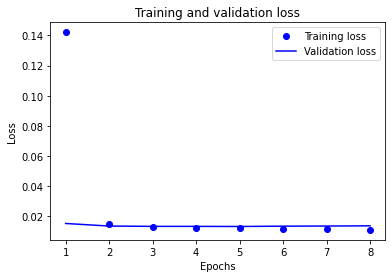

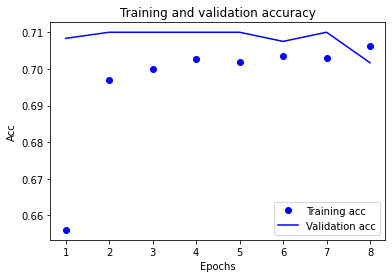

The Spearman's correlation coefficient is: 0.433
The Spearman's correlation coefficient is: 0.182
RMSE on train data: 0.1165280846564175


In [0]:
from tensorflow.python.keras.callbacks import EarlyStopping
Y = labels[['short-term_memorability','long-term_memorability']].values
X = in_count_vect
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)
n_cols = X_train.shape[1]


# Setting up the model using Sequential model
model1 = Sequential()
# Add the first layer
model1.add(layers.Dense(50, activation='relu', input_shape=(n_cols,)))
# Add the second layer
model1.add(layers.Dropout(0.6)) #Dropout consists in randomly setting a fraction rate of input units to 0 at each update during training; helps prevent overfitting.
model1.add(layers.Dense(32, activation='relu'))
# Add the third layer
model1.add(layers.Dense(32, activation='relu'))

# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=3)

# Add the output layer
model1.add(layers.Dense(2))

# compile the model 
model1.compile(optimizer='rmsprop',loss='mse',metrics=['accuracy'])

# training the model 
history = model1.fit(X_train,Y_train,epochs=30,validation_data=(X_test,Y_test),callbacks= [early_stopping_monitor])

# visualizing the model
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

cv_nn_predictions = model1.predict(X_test)
Get_score(cv_nn_predictions, Y_test)
error=cv_nn_predictions-Y_test
print('RMSE on train data: {}'.format(((error**2).mean())**0.5))

*   Input Feature extracted using : **CountVectorizer**
*   Model                         : **Decision Tree Regressor**

In [0]:
from sklearn.tree import DecisionTreeRegressor
dt1 = DecisionTreeRegressor()
dt1.fit(X_train, Y_train)

cv_dt1_predictions = dt1.predict(X_test)
Get_score(cv_dt1_predictions, Y_test)

The Spearman's correlation coefficient is: 0.288
The Spearman's correlation coefficient is: 0.131


*   Input Feature extracted using : **CountVectorizer**
*   Model                         : **Random Forest Regressor**

In [0]:
from sklearn.ensemble import RandomForestRegressor
rf1 = RandomForestRegressor(n_estimators=50)
rf1.fit(X_train, Y_train)

cv_rf1_predictions = rf1.predict(X_test)
Get_score(cv_rf1_predictions, Y_test)

The Spearman's correlation coefficient is: 0.400
The Spearman's correlation coefficient is: 0.180


*   Input Feature extracted using : **One-Hot Encoding**
*   Model                         : **Sequential Neural Network**

Epoch 1/30
150/150 [==============================] - 1s 6ms/step - loss: 0.0928 - accuracy: 0.5640 - val_loss: 0.0140 - val_accuracy: 0.7100
Epoch 2/30
150/150 [==============================] - 1s 6ms/step - loss: 0.0145 - accuracy: 0.6985 - val_loss: 0.0135 - val_accuracy: 0.7100
Epoch 3/30
150/150 [==============================] - 1s 6ms/step - loss: 0.0130 - accuracy: 0.7040 - val_loss: 0.0132 - val_accuracy: 0.7100
Epoch 4/30
150/150 [==============================] - 1s 6ms/step - loss: 0.0125 - accuracy: 0.7052 - val_loss: 0.0132 - val_accuracy: 0.7100
Epoch 5/30
150/150 [==============================] - 1s 6ms/step - loss: 0.0120 - accuracy: 0.7031 - val_loss: 0.0131 - val_accuracy: 0.7100
Epoch 6/30
150/150 [==============================] - 1s 6ms/step - loss: 0.0116 - accuracy: 0.7046 - val_loss: 0.0134 - val_accuracy: 0.7100
Epoch 7/30
150/150 [==============================] - 1s 6ms/step - loss: 0.0112 - accuracy: 0.7046 - val_loss: 0.0133 - val_accuracy: 0.7100
Epoch 

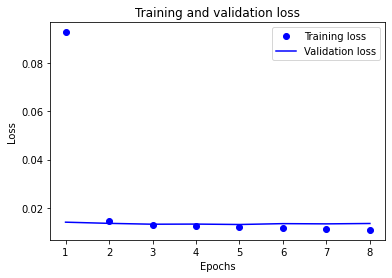

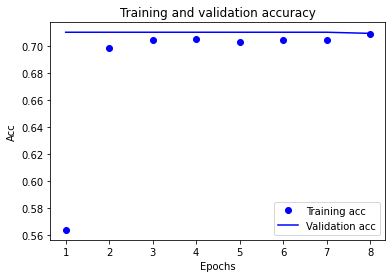

The Spearman's correlation coefficient is: 0.413
The Spearman's correlation coefficient is: 0.179
RMSE on train data: 0.11596750708814915


In [0]:
Y = labels[['short-term_memorability','long-term_memorability']].values
X = in_one_hot;
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)
n_cols = X_train.shape[1]

# Setting up the model using Sequential model
model2 = Sequential()
# Add the first layer
model2.add(layers.Dense(50, activation='relu', input_shape=(n_cols,)))
# Add the second layer
model2.add(layers.Dropout(0.6)) #Dropout consists in randomly setting a fraction rate of input units to 0 at each update during training; helps prevent overfitting.
model2.add(layers.Dense(32, activation='relu'))
# Add the third layer
model2.add(layers.Dense(32, activation='relu'))

# Add the output layer
model2.add(layers.Dense(2))

# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=3)

# compile the model 
model2.compile(optimizer='rmsprop',loss='mse',metrics=['accuracy'])

# training the model 
hist = model2.fit(X_train,Y_train,epochs=30,validation_data=(X_test,Y_test),callbacks= [early_stopping_monitor])

# visualizing the model
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

onehot_nn_predictions = model2.predict(X_test)
Get_score(onehot_nn_predictions, Y_test)
error=onehot_nn_predictions-Y_test
print('RMSE on train data: {}'.format(((error**2).mean())**0.5))

*   Input Feature extracted using : **One-Hot Encoding**
*   Model                         : **Decision Tree Regressor**

In [0]:
dt2 = DecisionTreeRegressor()
dt2.fit(X_train, Y_train)

onehot_dt2_predictions = dt2.predict(X_test)
Get_score(onehot_dt2_predictions, Y_test)

The Spearman's correlation coefficient is: 0.283
The Spearman's correlation coefficient is: 0.130


*   Input Feature extracted using : **One-Hot Encoding**
*   Model                         : **Random Forest Regressor**

In [0]:
rf2 = RandomForestRegressor(n_estimators=50)
rf2.fit(X_train, Y_train)

onehot_rf2_prediction = rf2.predict(X_test)
Get_score(onehot_rf2_prediction, Y_test)

The Spearman's correlation coefficient is: 0.414
The Spearman's correlation coefficient is: 0.169


*   Input Feature extracted using : **TfidfVectorizer**
*   Model                         : **Sequential Neural Network**

Epoch 1/30
150/150 [==============================] - 1s 5ms/step - loss: 0.0897 - accuracy: 0.6677 - val_loss: 0.0138 - val_accuracy: 0.7100
Epoch 2/30
150/150 [==============================] - 1s 4ms/step - loss: 0.0143 - accuracy: 0.7019 - val_loss: 0.0132 - val_accuracy: 0.7100
Epoch 3/30
150/150 [==============================] - 1s 5ms/step - loss: 0.0126 - accuracy: 0.7031 - val_loss: 0.0131 - val_accuracy: 0.7100
Epoch 4/30
150/150 [==============================] - 1s 5ms/step - loss: 0.0121 - accuracy: 0.7035 - val_loss: 0.0131 - val_accuracy: 0.7100
Epoch 5/30
150/150 [==============================] - 1s 4ms/step - loss: 0.0117 - accuracy: 0.7044 - val_loss: 0.0131 - val_accuracy: 0.7100
Epoch 6/30
150/150 [==============================] - 1s 5ms/step - loss: 0.0113 - accuracy: 0.7013 - val_loss: 0.0132 - val_accuracy: 0.7067


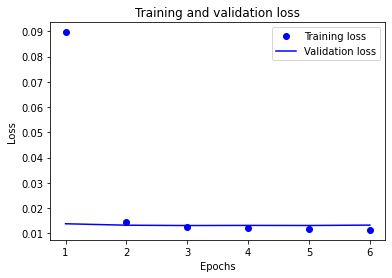

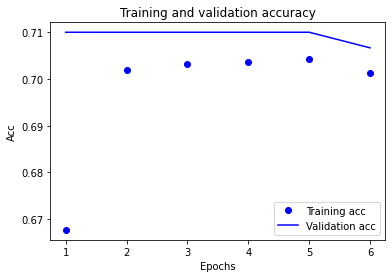

The Spearman's correlation coefficient is: 0.436
The Spearman's correlation coefficient is: 0.207
RMSE on train data: 0.11488954519680478


In [0]:
Y = labels[['short-term_memorability','long-term_memorability']].values
X = in_tfidf;
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)
n_cols = X_train.shape[1]

# Setting up the model using Sequential model
model3 = Sequential()
# Add the first layer
model3.add(layers.Dense(50, activation='relu', input_shape=(n_cols,)))
# Add the second layer
model3.add(layers.Dropout(0.6)) #Dropout consists in randomly setting a fraction rate of input units to 0 at each update during training; helps prevent overfitting.
model3.add(layers.Dense(32, activation='relu'))
# Add the third layer
model3.add(layers.Dense(32, activation='relu'))

# Add the output layer
model3.add(layers.Dense(2))

# compile the model 
model3.compile(optimizer='rmsprop',loss='mse',metrics=['accuracy'])

# training the model 
hist = model3.fit(X_train,Y_train,epochs=30,validation_data=(X_test,Y_test),callbacks= [early_stopping_monitor])

# visualizing the model
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

tfidf_nn_predictions = model3.predict(X_test)
Get_score(tfidf_nn_predictions, Y_test)
error=tfidf_nn_predictions-Y_test
print('RMSE on train data: {}'.format(((error**2).mean())**0.5))

*   Input Feature extracted using : **TfidfVectorizer**
*   Model                         : **Decision Tree Regressor**

In [0]:
dt3 = DecisionTreeRegressor()
dt3.fit(X_train, Y_train)

tfidf_dt3_predictions = dt3.predict(X_test)
Get_score(tfidf_dt3_predictions, Y_test)

The Spearman's correlation coefficient is: 0.249
The Spearman's correlation coefficient is: 0.134


*   Input Feature extracted using : **TfidfVectorizer**
*   Model                         : **Random Forest Regressor**

In [0]:
rf3 = RandomForestRegressor(n_estimators=50)
rf3.fit(X_train, Y_train)

tfidf_rf3_predictions = rf3.predict(X_test)
Get_score(tfidf_rf3_predictions, Y_test)

The Spearman's correlation coefficient is: 0.379
The Spearman's correlation coefficient is: 0.151


**Section 5** : Building Ensemble models with the best predictions

For building the weighted ensemble models, the predictions of sequential NN model using TfidfVectorizer and Random Forest Regression model using CountVectorizer are used as these models produced best results for both short-term and long-term memorability.. 

In [0]:
#concatenating the best predictions of two different models
train_predictions = np.concatenate([cv_rf1_predictions,
                                    tfidf_nn_predictions], axis=1)



In [0]:
#seperating the short-term and long-term predictions
train_short = train_predictions[:,[0,2]]
train_long = train_predictions[:,[1,3]]

label_short = Y_test[:,[0]]
label_long = Y_test[:,[1]]

In [0]:
#generating optimal weights for short-term predictions
from sklearn.metrics import mean_squared_error
def objective_short(weights):
    """ Calculate the score of a weighted average of predictions
  
    Parameters
    ----------
    weights: array
        the weights applied to the average of the base predictions
        
    Returns
    -------
    float
        The mean_squared_error score of the ensemble
    """
    y_ens = np.average(train_short, axis=1, weights=weights)
    return mean_squared_error(label_short, y_ens)

In [0]:
#generating optimal weights for long-term predictions
def objective_long(weights):
    """ Calculate the score of a weighted average of predictions
  
    Parameters
    ----------
    weights: array
        the weights applied to the average of the base predictions
        
    Returns
    -------
    float
        The mean_squared_error score of the ensemble
    """
    y_ens = np.average(train_long, axis=1, weights=weights)
    return mean_squared_error(label_long, y_ens)

In [0]:
from scipy.optimize import minimize

# equal weights are set initially for both the models
w0 = np.empty(train_long.shape[1])
w0.fill(.50)
# define bounds, i.e. lower and upper values of weights.
# the weights to be between 0 and 1.
bounds = [(0,1)] * 2

# setting some constraints. Here, the sum of the weights to be equal to 1
cons = [{'type': 'eq',
         'fun': lambda w: w.sum() - 1}]

In [0]:
# Finding the weights that will minimize my objective function.
# There are several solvers (methods) to choose from. I choose Nelder-Mead over SLSQP as the former produced efficient weights
res = minimize(objective_short,
               w0,
               #method='SLSQP',
               method='Nelder-Mead',
               bounds=bounds,
               options={'disp':True, 'maxiter':10000},
               constraints=cons)
weights_short = res.x
print('\nOptimized weights:')
print('Model 1: {:.4f}'.format(weights_short[0]))
print('Model 2: {:.4f}'.format(weights_short[1]))

Optimization terminated successfully.
         Current function value: 0.004822
         Iterations: 38
         Function evaluations: 75

Optimized weights:
Model 1: 0.4448
Model 2: 0.5609


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


In [0]:
# Finding the weights that will minimize my objective function.
# There are several solvers (methods) to choose from. I choose Nelder-Mead over SLSQP as the former produced efficient weights
res = minimize(objective_long,
               w0,
               #method='SLSQP',
               method='Nelder-Mead',
               bounds=bounds,
               options={'disp':True, 'maxiter':10000},
               constraints=cons)
weights_long = res.x
print('\nOptimized weights:')
print('Model 1: {:.4f}'.format(weights_long[0]))
print('Model 2: {:.4f}'.format(weights_long[1]))

Optimization terminated successfully.
         Current function value: 0.020981
         Iterations: 51
         Function evaluations: 96

Optimized weights:
Model 1: 0.2417
Model 2: 0.7526


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


**Section 6** : Results

Scores with Ensemble 1 using the optimal weights for short-term memorabilty prediction

In [0]:
ensemble1  = weights_short[0]*cv_rf1_predictions + weights_short[1]*tfidf_nn_predictions
Get_score(ensemble1, Y_test)

The Spearman's correlation coefficient is: 0.456
The Spearman's correlation coefficient is: 0.219


Scores with Ensemble 2 using the optimal weights for long-term memorabilty prediction

In [0]:
ensemble2  = weights_long[0]*cv_rf1_predictions + weights_long[1]*tfidf_nn_predictions
Get_score(ensemble2, Y_test)

The Spearman's correlation coefficient is: 0.460
The Spearman's correlation coefficient is: 0.223


Both the ensemble models got better scores than individual models

Text(0, 0.5, 'long-term')

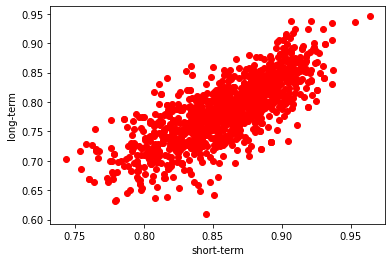

In [0]:
ensemble1.min(axis=0)
ensemble1.max(axis=0)
plt.figure()
plt.scatter(ensemble1[:,0],ensemble1[:,1],marker='o',c='r')
plt.xlabel('short-term')
plt.ylabel('long-term')

Text(0, 0.5, 'long-term')

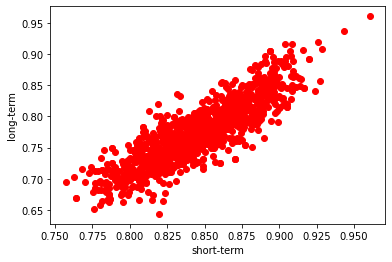

In [0]:
ensemble2.min(axis=0)
ensemble2.max(axis=0)
plt.figure()
plt.scatter(ensemble2[:,0],ensemble2[:,1],marker='o',c='r')
plt.xlabel('short-term')
plt.ylabel('long-term')

In [0]:
ensemble1_results = pd.DataFrame()
ensemble2_results = pd.DataFrame()

In [0]:
ensemble1_results['short-term'] = ensemble1[:,0]
ensemble1_results['long-term'] = ensemble1[:,1]

In [0]:
ensemble2_results['short-term'] = ensemble2[:,0]
ensemble2_results['long-term'] = ensemble2[:,1]

In [0]:
ensemble1_results.head()

,short-term,long-term
0,0.885587,0.786740
1,0.865027,0.799861
2,0.872851,0.811614
3,0.788447,0.725634
4,0.879213,0.786784


In [0]:
ensemble2_results.head()

,short-term,long-term
0,0.876418,0.782885
1,0.853919,0.786868
2,0.854980,0.792605
3,0.783276,0.707523
4,0.854408,0.766808


In [0]:
ensemble1_results.describe()

,short-term,long-term
count,1200.000000,1200.000000
mean,0.859805,0.787050
std,0.035754,0.053974
min,0.743243,0.609621
25%,0.836318,0.752687
50%,0.862840,0.790780
75%,0.885342,0.823616
max,0.964067,0.945833


In [0]:
ensemble2_results.describe()

,short-term,long-term
count,1200.000000,1200.000000
mean,0.846658,0.776388
std,0.032300,0.049267
min,0.757115,0.643878
25%,0.823413,0.742616
50%,0.846814,0.775839
75%,0.869877,0.808721
max,0.960744,0.960376


The predictions of Ensemble 2 is printed in the CSV file as it produced slightly better results than Ensemble 1

In [0]:
#ensemble1_results.to_csv("/content/drive/My Drive/Results_En1.csv",index=False)

In [0]:
ensemble2_results.to_csv("/content/drive/My Drive/Results_En2.csv",index=False)